In [1]:
import pygame, sys
import math
import random as rn
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize': [8,5]})

sys.path.append('procedural_tracks/')
from procedural_tracks.main import *

np.set_printoptions(precision=3, suppress=True)

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# helper functions

def get_track_points_from_random_track(seed=8, sample=20):
    rn.seed(seed)  
    points = random_points()
    hull = ConvexHull(points)
    track_points_coarse = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points_coarse)
    track_points = smooth_track(track_points_coarse)[::sample]
    return track_points

def racing_line_length(points): 
    x,y = zip(*points)
    num_points = len(points)
    length = np.sum([np.sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2) 
                     for i in range(num_points-1)])
    return length

# this is slightly incorrect, the new point can be (max_offset, max_offset) away
# use a 2d gaussian instead?
def get_new_point(old_point, baseline, spread, max_offset_from_baseline):
    old_x, old_y = old_point
    baseline_x, baseline_y = baseline
    while True:
        potential_x = old_x + (np.random.random()-0.5) * spread
        if abs(potential_x - baseline_x) < max_offset_from_baseline:
            new_x = potential_x
            break
    while True:
        potential_y = old_y + (np.random.random()-0.5) * spread
        if abs(potential_y - baseline_y) < max_offset_from_baseline:
            new_y = potential_y
            break
    return new_x, new_y

In [33]:
# cost functions

def racing_line_length_full(points_except_last, params={}): 
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x,y = zip(*points)
    num_points = len(points)
    length = np.sum([np.sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2) 
                     for i in range(num_points-1)])
    return length

def _angle_between(vector1, vector2):
        vector1_unit = vector1 / np.linalg.norm(vector1)
        vector2_unit = vector2 / np.linalg.norm(vector2)
        return np.arccos(np.clip(np.dot(vector1_unit, vector2_unit), -1.0, 1.0))    
    
def sum_of_angles(points_except_last, params={}):
    num_points = len(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    
    vectors = [(points[i+1][0] - points[i][0], points[i+1][1] - points[i][1]) for i in range(num_points)]
    vectors += [vectors[0]]
    angles = [abs_angle_between(vectors[i], vectors[i+1]) for i in range(len(vectors)-1)]
    return np.std(angles), angles
    
def _length_and_angles(points_except_last):
#     length = racing_line_length_full(points_except_last)
#     angles = sum_of_angles(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x,y = zip(*points)
    num_points = len(points)
    vectors = [(x[i+1] - x[i], y[i+1] - y[i]) for i in range(num_points-1)]
    vectors += [vectors[0]]
    
    length = np.sum([np.sqrt(vectors[i][0]**2 + vectors[i][1]**2) for i in range(len(vectors)-1)])
    angles = np.std([_angle_between(vectors[i], vectors[i+1]) for i in range(len(vectors)-1)])
    
    return (length, angles)

def length_and_angles(points_except_last, params={'reg_param': 0.0, 'init_cost': (1.0, 1.0)}):
    reg_param = params['reg_param']
    init_cost = params['init_cost']
    
    length, angles = _length_and_angles(points_except_last)
    length_init, angles_init = init_cost
    length_normalized = length / length_init
    angles_normalized = angles / angles_init
    
    cost = length_normalized + reg_param * angles_normalized
    return cost

In [4]:
# optimization functions

def opt_random_perturbation(track_midpoints, compute_cost=racing_line_length_full,
                            spread=10, iterations=100, track_width=0.65,
                            debug=False, debug_iter=1000):
    
    best_racing_line = []
    best_racing_line_cost = np.inf
    num_track_points = np.array(track_midpoints).shape[0]
    max_offset_from_baseline = track_width/2
    racing_line = [0] * (num_track_points)
    
    for iteration in range(iterations):
        for i in range(num_track_points):
            new_x, new_y = get_new_point(track_midpoints[i], track_midpoints[i], 
                                         spread, max_offset_from_baseline)
            racing_line[i] = (new_x, new_y)
        cost = compute_cost(racing_line)
        if cost < best_racing_line_cost:
            best_racing_line = copy.deepcopy(racing_line)
            best_racing_line_cost = cost
        if debug:
            if iteration % debug_iter == 0:
                print(f'Best hiterto: {best_racing_line_cost:.3f}')
    return best_racing_line, best_racing_line_cost

def opt_iterative_improvement(track_midpoints, compute_cost=racing_line_length_full,
                              cost_func_params={},
                              spread=10, iterations=100, track_width=0.65,
                              debug=False, debug_iter=1000):
    
    num_track_points = np.array(track_midpoints).shape[0]
    racing_line_old = copy.deepcopy(track_midpoints)
    racing_line_new = copy.deepcopy(racing_line_old)
    max_offset_from_baseline = track_width/2
    init_cost = compute_cost(racing_line_old)
    print(f'Started with: {init_cost}')
    min_cost_so_far = init_cost
    
    for iteration in range(iterations):
        min_cost_iter = min_cost_so_far
        point = (-1, (0,0))
        for i in range(num_track_points):
            new_x, new_y = get_new_point(racing_line_old[i], track_midpoints[i], 
                                         spread, max_offset_from_baseline)
            racing_line_new[i] = (new_x, new_y)
            cost = compute_cost(racing_line_new, cost_func_params)
            if cost < min_cost_iter:
                point = (i, (new_x, new_y))
                min_cost_iter = cost
            racing_line_new[i] = racing_line_old[i]
        if min_cost_iter < min_cost_so_far:
            racing_line_new[point[0]] = point[1]
            min_cost_so_far = min_cost_iter
        if debug:
            if iteration % debug_iter == 0:
                print(f'Smallest hiterto: {min_cost_so_far:.3f}')
                #print(np.array(racing_line_new))
        racing_line_old = copy.deepcopy(racing_line_new)
    
    print(f'\nEnded with: {compute_cost(racing_line_new)}\n')
    return racing_line_new

In [5]:
# visualization functions

def draw_track_and_racing_line(track_points, racing_line, track_width, 
                               compute_cost=racing_line_length_full,
                               xlims=None, ylims=None):
    track_points_x, track_points_y = zip(*track_points)
    plt.scatter(track_points_x, track_points_y, s=1000*track_width, color='black', facecolor='None')
    if xlims != None:
        plt.xlim((-2, 6))
    if ylims != None:
        plt.ylim((-2, 6))
    print(compute_cost(racing_line))
    racing_line = copy.deepcopy(racing_line)
    racing_line += [racing_line[0]]
    x, y = zip(*racing_line)
    plt.plot(x, y)
    #print(f'Length of racing line: {racing_line_length(racing_line):.3f}')
    
def draw_complete_track(track_seed=8, racing_line=None):
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    background_color = GRASS_GREEN
    screen.fill(background_color)
    
    rn.seed(track_seed)  # 8 is a nice simple track
    points = random_points()
    hull = ConvexHull(points)
    track_points = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points)
    f_points = smooth_track(track_points)
    # get complete corners from keypoints
    corners = get_full_corners(f_points, corner_points)
    # draw the actual track (road, kerbs, starting grid)
    draw_track(screen, GREY, f_points, corners)
    # draw racing line
    draw_lines_from_points(screen, BLUE, racing_line)
    # draw checkpoints
    checkpoints = get_checkpoints(f_points)

    pygame.display.set_caption(TITLE)
    while True: # main loop
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                sys.exit()
        pygame.display.update()

### Loading and checking a sample track

In [9]:
rn.seed(8)  # 8 is a nice simple track
points = random_points()
hull = ConvexHull(points)
track_points = shape_track(get_track_points(hull, points))
corner_points = get_corners_with_kerb(track_points)
f_points = smooth_track(track_points)
# get complete corners from keypoints
corners = get_full_corners(f_points, corner_points)

In [10]:
len(f_points)

1000

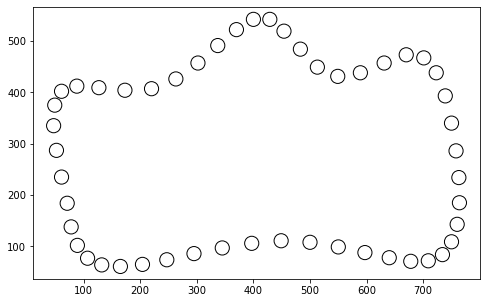

In [11]:
track_midpoints = np.array(f_points)
track_midpoints_x, track_midpoints_y = zip(*track_midpoints)
plt.scatter(track_midpoints_x[::20], track_midpoints_y[::20], s=200, color='black', facecolor='None')

## Sanity checks on smaller tracks

In [7]:
track_points = [[0,0], [4,0], [4,4], [0,4]]
track_width = 2

16.0
16.0 6.283185307179586


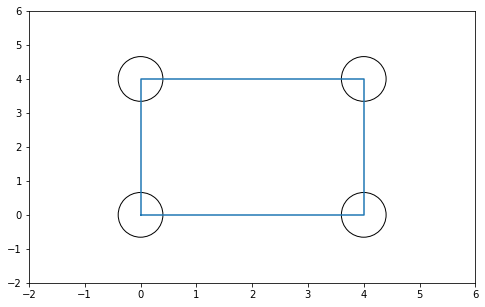

In [76]:
draw_track_and_racing_line(track_points, track_points, track_width, xlims=(-2,6), ylims=(-2,6))
length_init, angles_init = _length_and_angles(track_points)
print(length_init, angles_init)

13.74221285558294


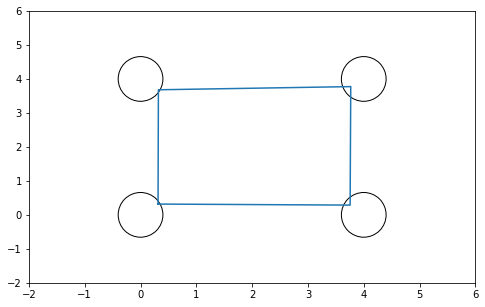

In [8]:
# Compute shortest racing line using the random-perturbation algorithm

shortest_racing_line, _ = opt_random_perturbation(track_points, spread=0.8, iterations=100000)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

Started with: 16.0

Ended with: 13.468513376266502

13.468513376266502


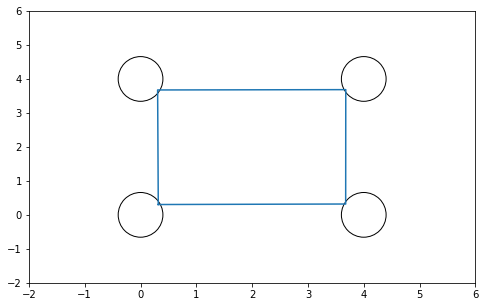

In [11]:
# Compute shortest racing line using the iterative-improvement algorithm

shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

Started with: 16.0

Ended with: 13.468211083972049

13.468211083972049


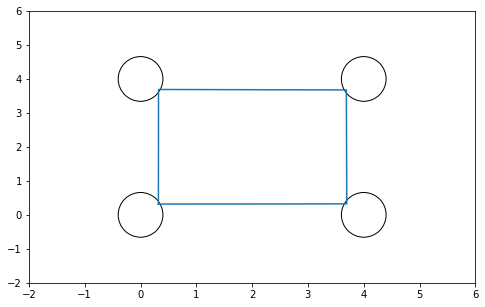

In [80]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.5, 'init_cost': init_cost},
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

Started with: 16.0

Ended with: 12.497661212919542

12.497661212919542


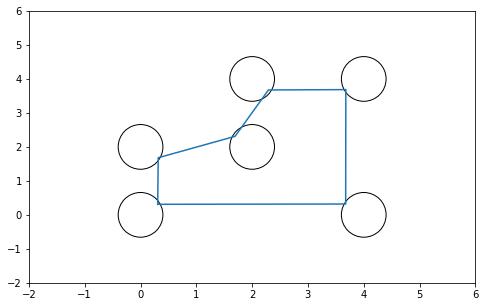

In [11]:
# new track
track_points = [[0,0], [4,0], [4,4], [2,4], [2,2], [0,2]]

shortest_racing_line = opt_iterative_improvement(track_points, spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2, xlims=(-2,6), ylims=(-2,6))

In [ ]:
# new track
track_points = [[0,0], [2,0], [4,0], [4,2], [4,4], [2,4], [2,2], [0,2]]

shortest_racing_line = opt_iterative_improvement(track_points, spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

In [ ]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.0, 'init_cost': init_cost},
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

Seems to be working well enough. Back to the larger track(s).

In [36]:
rn.seed(8)  # 8 is a nice simple track
points = random_points()
hull = ConvexHull(points)
track_points_coarse = shape_track(get_track_points(hull, points))
corner_points = get_corners_with_kerb(track_points_coarse)
track_points = smooth_track(track_points_coarse)[::20]

2124.290518902025
(11.68393303490195, [0.5880026035475675, 0.1661557264196127, 0.01674809436477145, 0.0993002680782069, 0.2555416505299176, 0.35232119319113586, 0.17201390339314251, 0.03149869959067603, 0.4314775432807184, 0.7978663452047272, 0.3682659338572867, 0.15375073617898696, 0.06758678593246611, 0.02224286646643629, 0.04260664993458749, 0.14553046614834145, 0.327477243907056, 0.46725398182554345, 0.388859404791851, 0.1928666053079989, 0.10411717592246414, 0.038654769097147164, 0.02842835815077074, 0.04517117858658033, 0.07551997927949397, 0.15461496982573647, 0.11933711551547534, 0.051811489900708475, 0.0014077888401242233, 0.04632832881909838, 0.21441519290801725, 0.415273092721916, 0.553963160537065, 0.28326174938334325, 0.19109973537456187, 0.1153570370292938, 0.07545381642347347, 0.05121920827839081, 0.05756345444137558, 0.1369736808180283, 0.30738006834869347, 0.7306163082013813, 0.580501181430155, 0.03551544108620174, 0.2515864964669778, 0.6368932754531711, 0.398522445666

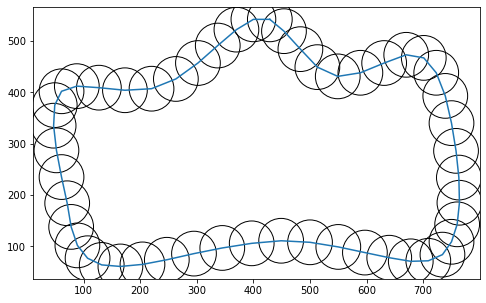

In [37]:
draw_track_and_racing_line(track_points, track_points, track_width=2)#, xlims=(-2,6), ylims=(-2,6))
print(length_and_turns(track_points))

Started with: 2124.290518902025

Ended with: 1778.5063393491725

1778.5063393491725


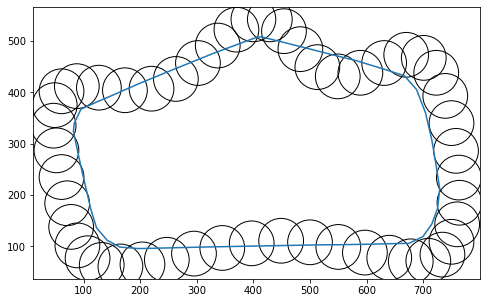

In [16]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full,
                           track_width=2)#, xlims=(-2,6), ylims=(-2,6))

Ooh la la

In [17]:
# will open a new window, closing which throws the following (harmless) exception
draw_complete_track(racing_line=shortest_racing_line)

FileNotFoundError: No such file or directory.

2263.023804183427


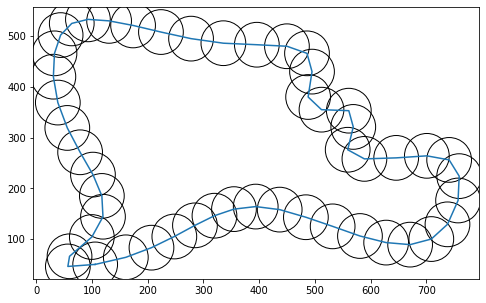

In [43]:
# new track

track_points = get_track_points_from_random_track(seed=123, sample=20)
draw_track_and_racing_line(track_points, track_points, track_width=2)

Started with: 2263.023804183427

Ended with: 1812.828955491602

1812.828955491602


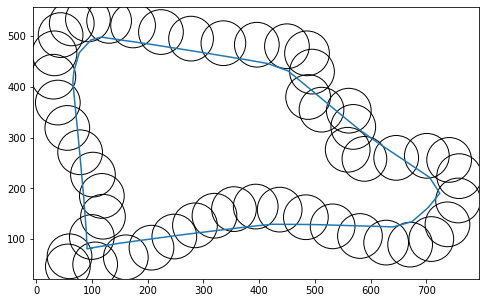

In [44]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full, track_width=2)

2008.7614738659981
(2008.7614738659981, 0.30412922956821625)


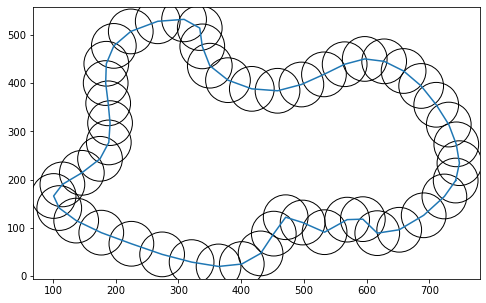

In [36]:
# new track

track_points = get_track_points_from_random_track(seed=95521, sample=20)
draw_track_and_racing_line(track_points, track_points, track_width=2)
print(_length_and_angles(track_points))

Started with: 2008.7614738659981

Ended with: 1566.932164982755

1566.932164982755
(1566.932164982755, 0.23213253894979993)


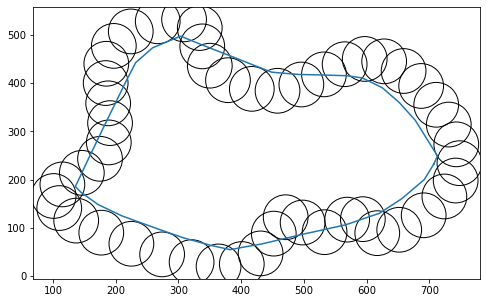

In [34]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full, track_width=2)
print(_length_and_angles(shortest_racing_line))

### In quest for a more realistic cost function

Started with: 2008.7614738659981
Smallest hiterto: 1.986
Smallest hiterto: 1.375
Smallest hiterto: 1.289
Smallest hiterto: 1.268
Smallest hiterto: 1.239
Smallest hiterto: 1.216
Smallest hiterto: 1.201
Smallest hiterto: 1.182
Smallest hiterto: 1.175
Smallest hiterto: 1.168
Smallest hiterto: 1.165
Smallest hiterto: 1.160
Smallest hiterto: 1.159
Smallest hiterto: 1.155
Smallest hiterto: 1.155
Smallest hiterto: 1.152
Smallest hiterto: 1.152
Smallest hiterto: 1.152
Smallest hiterto: 1.151
Smallest hiterto: 1.151

Ended with: 1986.6807766904763

1986.6807766904763
(1986.6807766904763, 0.04897945231053672)


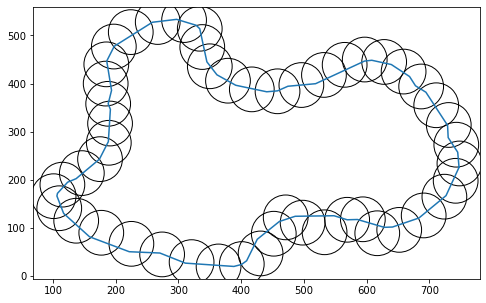

In [35]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 1, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.471
Smallest hiterto: 1.173
Smallest hiterto: 1.112
Smallest hiterto: 1.090
Smallest hiterto: 1.077
Smallest hiterto: 1.072
Smallest hiterto: 1.070
Smallest hiterto: 1.067
Smallest hiterto: 1.066
Smallest hiterto: 1.064
Smallest hiterto: 1.062
Smallest hiterto: 1.060
Smallest hiterto: 1.059
Smallest hiterto: 1.055
Smallest hiterto: 1.055
Smallest hiterto: 1.055
Smallest hiterto: 1.054
Smallest hiterto: 1.054
Smallest hiterto: 1.054
Smallest hiterto: 1.053

Ended with: 1980.2416334771044

1980.2416334771044
(1980.2416334771044, 0.04094787518217246)


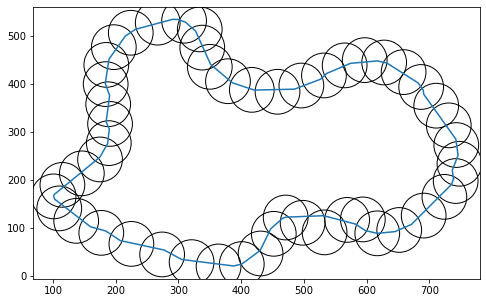

In [37]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.5, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.087
Smallest hiterto: 1.017
Smallest hiterto: 1.004
Smallest hiterto: 1.000
Smallest hiterto: 0.995
Smallest hiterto: 0.994
Smallest hiterto: 0.990
Smallest hiterto: 0.989
Smallest hiterto: 0.986
Smallest hiterto: 0.986
Smallest hiterto: 0.985
Smallest hiterto: 0.985
Smallest hiterto: 0.984
Smallest hiterto: 0.984
Smallest hiterto: 0.984
Smallest hiterto: 0.983
Smallest hiterto: 0.983
Smallest hiterto: 0.983
Smallest hiterto: 0.982
Smallest hiterto: 0.981

Ended with: 1931.9440987935475

1931.9440987935475
(1931.9440987935475, 0.058733565106650475)


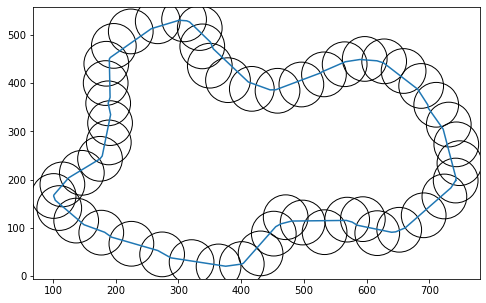

In [38]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.1, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.030
Smallest hiterto: 0.965
Smallest hiterto: 0.952
Smallest hiterto: 0.942
Smallest hiterto: 0.934
Smallest hiterto: 0.928
Smallest hiterto: 0.922
Smallest hiterto: 0.918
Smallest hiterto: 0.915
Smallest hiterto: 0.913
Smallest hiterto: 0.913
Smallest hiterto: 0.913
Smallest hiterto: 0.913
Smallest hiterto: 0.912
Smallest hiterto: 0.912
Smallest hiterto: 0.911
Smallest hiterto: 0.911
Smallest hiterto: 0.911
Smallest hiterto: 0.910
Smallest hiterto: 0.910

Ended with: 1812.13591221577

1812.13591221577
(1812.13591221577, 0.08289855824433594)


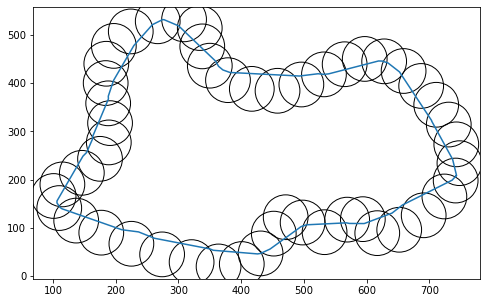

In [43]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.03, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.005
Smallest hiterto: 0.913
Smallest hiterto: 0.885
Smallest hiterto: 0.866
Smallest hiterto: 0.857
Smallest hiterto: 0.854
Smallest hiterto: 0.851
Smallest hiterto: 0.845
Smallest hiterto: 0.842
Smallest hiterto: 0.841
Smallest hiterto: 0.841
Smallest hiterto: 0.840
Smallest hiterto: 0.837
Smallest hiterto: 0.830
Smallest hiterto: 0.824
Smallest hiterto: 0.824
Smallest hiterto: 0.823
Smallest hiterto: 0.823
Smallest hiterto: 0.823
Smallest hiterto: 0.823

Ended with: 1642.2472904587025

1642.2472904587025
(1642.2472904587025, 0.15519161946613436)


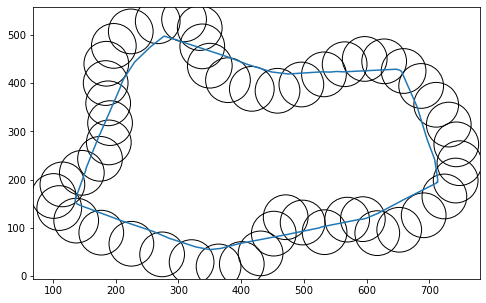

In [40]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.01, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.010
Smallest hiterto: 0.944
Smallest hiterto: 0.918
Smallest hiterto: 0.911
Smallest hiterto: 0.899
Smallest hiterto: 0.892
Smallest hiterto: 0.890
Smallest hiterto: 0.886
Smallest hiterto: 0.881
Smallest hiterto: 0.880
Smallest hiterto: 0.879
Smallest hiterto: 0.878
Smallest hiterto: 0.877
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.875
Smallest hiterto: 0.875
Smallest hiterto: 0.869

Ended with: 1726.7941990368272

1726.7941990368272
(1726.7941990368272, 0.1328900414909041)


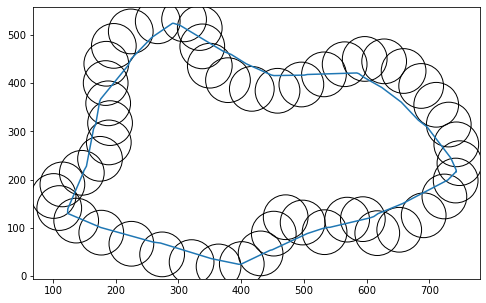

In [41]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.02, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.009
Smallest hiterto: 0.937
Smallest hiterto: 0.909
Smallest hiterto: 0.898
Smallest hiterto: 0.890
Smallest hiterto: 0.886
Smallest hiterto: 0.883
Smallest hiterto: 0.881
Smallest hiterto: 0.880
Smallest hiterto: 0.879
Smallest hiterto: 0.877
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.876
Smallest hiterto: 0.875
Smallest hiterto: 0.875
Smallest hiterto: 0.875
Smallest hiterto: 0.875
Smallest hiterto: 0.875

Ended with: 1747.0415056172976

1747.0415056172976
(1747.0415056172976, 0.09667628630344972)


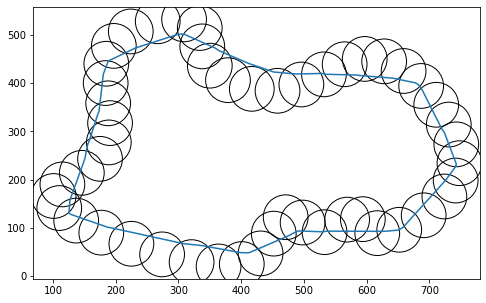

In [42]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.015, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))